In [ ]:
%matplotlib inline


# Compute LCMV inverse solution on evoked data in a mixed source space


Create a mixed source space and compute LCMV inverse solution on evoked dataset.



In [13]:
import os.path as op
import matplotlib.pyplot as plt
import mne
import numpy as np
from mne.datasets import sample
from mne import setup_source_space, setup_volume_source_space
from mne import make_forward_solution
from mne.minimum_norm import make_inverse_operator, apply_inverse
from mne.beamformer import make_lcmv, apply_lcmv
from nilearn.plotting import plot_stat_map
from nilearn.image import index_img


# Set dir
data_path = sample.data_path()
subject = 'sample'
data_dir = op.join(data_path, 'MEG', subject)
subjects_dir = op.join(data_path, 'subjects')
bem_dir = op.join(subjects_dir, subject, 'bem')

# Set file names
fname_mixed_src = op.join(bem_dir, '%s-oct-6-mixed-src.fif' % subject)
fname_aseg = op.join(subjects_dir, subject, 'mri', 'aseg.mgz')

fname_model = op.join(bem_dir, '%s-5120-bem.fif' % subject)
fname_bem = op.join(bem_dir, '%s-5120-bem-sol.fif' % subject)
raw_fname = data_path + '/MEG/sample/sample_audvis_raw.fif'
event_fname = data_path + '/MEG/sample/sample_audvis_raw-eve.fif'
fname_trans = data_dir + '/sample_audvis_raw-trans.fif'
fname_fwd = data_dir + '/sample_audvis-meg-oct-6-mixed-fwd.fif'


Set up our source space.



In [14]:
# Get a surface-based source space. 
surf = setup_source_space(subject, spacing='ico5', add_dist=False, subjects_dir=subjects_dir)
# Get a volume-based source space. 
labels_vol = ['Left-Hippocampus', 'Right-Hippocampus'] 
hippocampus= setup_volume_source_space(subject, mri=fname_aseg, pos=3.0, bem=fname_model,
    volume_label=labels_vol, mindist=3.0, subjects_dir=subjects_dir, verbose=True)

# Generate the mixed source space
src = surf+hippocampus
n = sum(src[i]['nuse'] for i in range(len(src)))
print('the src space contains %d spaces and %d points' % (len(src), n))



Setting up the source space with the following parameters:

SUBJECTS_DIR = C:\Users\PP255359\mne_data\MNE-sample-data\subjects
Subject      = sample
Surface      = white
Icosahedron subdivision grade 5

>>> 1. Creating the source space...

Doing the icosahedral vertex picking...
Loading C:\Users\PP255359\mne_data\MNE-sample-data\subjects\sample\surf\lh.white...
Mapping lh sample -> ico (5) ...
    Triangle neighbors and vertex normals...
Loading geometry from C:\Users\PP255359\mne_data\MNE-sample-data\subjects\sample\surf\lh.sphere...
    Triangle neighbors and vertex normals...
Setting up the triangulation for the decimated surface...
loaded lh.white 10242/155407 selected to source space (ico = 5)

Loading C:\Users\PP255359\mne_data\MNE-sample-data\subjects\sample\surf\rh.white...
Mapping rh sample -> ico (5) ...
    Triangle neighbors and vertex normals...
Loading geometry from C:\Users\PP255359\mne_data\MNE-sample-data\subjects\sample\surf\rh.sphere...
    Triangle neighbors and ver

Export source positions to nift file:



In [15]:
event_id, tmin, tmax = 1, -0.2, 0.5
# Setup for reading the raw data
raw = mne.io.read_raw_fif(raw_fname, preload=True)
raw.info['bads'] = ['MEG 2443', 'EEG 053']  # 2 bads channels
events = mne.read_events(event_fname)
# Set up pick list: EEG + MEG - bad channels 
left_temporal_channels = mne.read_selection('Left-temporal')
picks = mne.pick_types(raw.info, meg=True, eeg=False, stim=True, eog=True,
                       exclude='bads', selection=left_temporal_channels)
# Pick the channels of interest
raw.pick_channels([raw.ch_names[pick] for pick in picks])
# Re-normalize our empty-room projectors, so they are fine after subselection
raw.info.normalize_proj()
# Read epochs
proj = False  # already applied
epochs = mne.Epochs(raw, events, event_id, tmin, tmax,
                    baseline=(None, 0), preload=True, proj=proj,
                    reject=dict(grad=4000e-13, mag=4e-12, eog=150e-6))
evoked = epochs.average()
noise_cov = mne.compute_covariance(epochs, tmin=tmin, tmax=0, method='shrunk')
data_cov = mne.compute_covariance(epochs, tmin=0.04, tmax=0.15,
                                  method='shrunk')
# Compute the fwd matrix
fwd = make_forward_solution(evoked.info, fname_trans, src, fname_bem,
                            mindist=5.0,  # ignore sources<=5mm from innerskull
                            meg=True, eeg=False, n_jobs=1)

leadfield = fwd['sol']['data']
print("Leadfield size : %d sensors x %d dipoles" % leadfield.shape)

src_fwd = fwd['src']
n = sum(src_fwd[i]['nuse'] for i in range(len(src_fwd)))
print('the fwd src space contains %d spaces and %d points' % (len(src_fwd), n))



filters = make_lcmv(evoked.info, fwd, data_cov, reg=0.5,
                    noise_cov=noise_cov, pick_ori='max-power',
                    weight_norm='nai')
stc = apply_lcmv(evoked, filters, max_ori_out='signed')



Opening raw data file C:\Users\PP255359\mne_data\MNE-sample-data\MEG\sample\sample_audvis_raw.fif...
    Read a total of 3 projection items:
        PCA-v1 (1 x 102)  idle
        PCA-v2 (1 x 102)  idle
        PCA-v3 (1 x 102)  idle
    Range : 25800 ... 192599 =     42.956 ...   320.670 secs
Ready.
Current compensation grade : 0
Reading 0 ... 166799  =      0.000 ...   277.714 secs...
72 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
Created an SSP operator (subspace dimension = 3)
Loading data for 72 events and 421 original time points ...
    Rejecting  epoch based on EOG : [u'EOG 061']
    Rejecting  epoch based on EOG : [u'EOG 061']
    Rejecting  epoch based on EOG : [u'EOG 061']
    Rejecting  epoch based on EOG : [u'EOG 061']
    Rejecting  epoch based on EOG : [u'EOG 061']
    Rejecting  epoch based on EOG : [u'EOG 061']
    Rejecting  epoch based on EOG : [u'EOG 061']
    Rejecting  epoch based on EOG : [u'EOG 061']
    Rejecting  epoch 

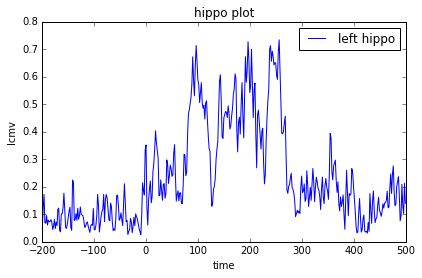

In [16]:
# take absolute values for plotting
stc.data[:, :] = np.abs(stc.data)
n_sources = 0
data_per_src= []
for s in fwd['src']:
    n_sources_in_s = s['inuse'].sum()
    this_data = stc.data[n_sources:n_sources + n_sources_in_s, :]
    n_sources += n_sources_in_s
    data_per_src.append(this_data)
hippo_lh = data_per_src[-2] #left hippocampus
left_hippo=np.mean(hippo_lh, axis=0)
hippo_rh= data_per_src[-1] #right hippocampus
right_hippo=np.mean(hippo_rh, axis=0)

            
src = fwd['src']
fig,axes=plt.subplots(1)
axes.plot(1e3*stc.times, left_hippo, label='left hippo')
#axes.plot(1e3*stc.times, right_hippo, 'k', label='right hippo')
axes.set(xlabel='time', ylabel='lcmv', title='hippo plot')
axes.legend()
mne.viz.tight_layout()
plt.show()

In [17]:
# Export result as a 4D nifti object
img = stc.as_volume(src,
                    mri_resolution=False)  # set True for full MRI resolution


t1_fname = data_path + '/subjects/sample/mri/T1.mgz'

# Plotting with nilearn ######################################################
plot_stat_map(index_img(img, 61), t1_fname, threshold=8.,
              title='%s (t=%.1f s.)' % (method, stc.times[61]))
plt.show()

AttributeError: 'MixedSourceEstimate' object has no attribute 'as_volume'